In [119]:
# # Install some packages
# %pip install rasterio
# %pip install earthpy

In [120]:
# Imports
import tensorflow_decision_forests as tfdf
import tensorflow as tf
import pandas as pd
import numpy as np
import rasterio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
import earthpy.plot as ep
import os

# Suppress TensorFlow INFO and WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

In [121]:
# Parameter
ALL_FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI', 'elevation']
LABEL = ['classvalue']
CLASSES = [1, 2, 3, 4, 5, 6]
PALETTE = ['#8B0100', '#B86401', '#008080', '#87CEFA', '#65A300', '#006401']
SAMPLE_PATH = 'ndvi_data/Samples_LC_Jambi_2023.csv'
IMAGE_PATH = 'ndvi_data/Landsat_Jambi_2023_ALLFEATURES.tif'

/home/seviko/python/py311/lib/python3.11/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


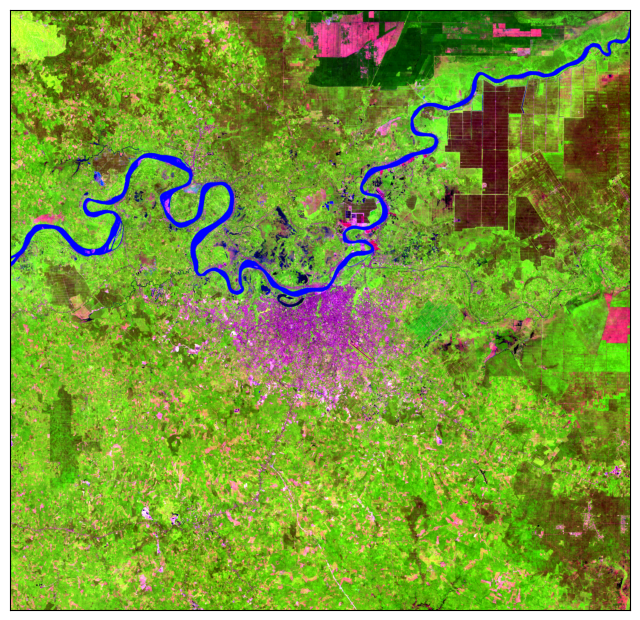

In [122]:
# Load image
image = rasterio.open(IMAGE_PATH)
height = image.height
width = image.width
shape = (height, width)

# (Optional) Visualize the image
image_vis = []
for x in [6, 5, 4]:
    image_vis.append(image.read(x))
image_vis = np.stack(image_vis)
ep.plot_rgb(image_vis, figsize=(8, 8), stretch=True)
plt.show()

In [123]:
# Read samples
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac=1)
# Ensure label is integer type
samples['classvalue'] = samples['classvalue'].astype('int32')
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
3887,0.026229,0.035785,0.073267,0.061209,0.224518,0.122424,0.058899,0.308506,0.584366,0.294268,-0.507917,-0.294268,0.350343,3,3,test
17068,0.010017,0.013235,0.033227,0.022283,0.238570,0.083800,0.033502,0.424759,0.753724,0.480101,-0.755498,-0.480101,0.428785,13,9,train
13384,0.026449,0.032939,0.053110,0.047610,0.228615,0.181246,0.089438,0.357087,0.437593,0.115573,-0.622966,-0.115573,0.339173,13,8,train
9327,0.018254,0.025376,0.051487,0.032004,0.337047,0.140766,0.054169,0.569644,0.723075,0.410790,-0.734966,-0.410790,0.444238,39,6,train
18256,0.011118,0.015545,0.033557,0.020797,0.248690,0.092517,0.040047,0.453287,0.722603,0.457705,-0.762212,-0.457705,0.395806,11,9,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,0.082672,0.104233,0.186787,0.233592,0.379232,0.341722,0.202545,0.182137,0.303703,0.052028,-0.339997,-0.052028,0.255715,50,2,train
18461,0.013867,0.017910,0.045162,0.028553,0.255427,0.108357,0.047830,0.438858,0.684559,0.404277,-0.699508,-0.404277,0.387531,12,9,train
4886,0.036610,0.047706,0.089479,0.073749,0.209351,0.099888,0.052560,0.261974,0.598643,0.353978,-0.401139,-0.353978,0.310451,7,4,train
5134,0.021540,0.029955,0.062872,0.049728,0.128543,0.060123,0.029707,0.163891,0.624550,0.362653,-0.343077,-0.362653,0.338584,9,4,train


In [124]:
# Split into train and test based on 'sample' column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Prepare data for TFDF
train_data = train[FEATURES + LABEL]
test_data = test[FEATURES + LABEL]

In [125]:
# Convert to TensorFlow datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=LABEL[0])
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=LABEL[0])

In [126]:
best_num_trees = 50
best_max_depth = 10
best_min_examples = 20

# Define and train the best model
rf_model = tfdf.keras.RandomForestModel(
    task=tfdf.keras.Task.CLASSIFICATION,
    num_trees=best_num_trees,
    max_depth=best_max_depth,
    min_examples=best_min_examples
)

rf_model.fit(train_ds)

# Evaluate the best model
best_evaluation = rf_model.evaluate(test_ds, return_dict=True)
print(f"Best Model Evaluation: {best_evaluation}")

Use /tmp/tmpynbmkt87 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.339196. Found 14853 examples.
Training model...


I0000 00:00:1732692447.657658   16565 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1732692447.657696   16565 kernel.cc:783] Collect training examples
I0000 00:00:1732692447.657707   16565 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1732692447.657771   16565 kernel.cc:401] Number of batches: 15
I0000 00:00:1732692447.657776   16565 kernel.cc:402] Number of examples: 14853
I0000 00:00:1732692447.659121   16565 kernel.cc:802] Training dataset:
Number of records: 14853
Number of columns: 15

Number of columns by type:
	NUMERICAL: 14 (93.3333%)
	CATEGORICAL: 1 (6.66667%)

Columns:

NUMERICAL: 14 (93.3333%)
	0: "B1" NUMERICAL mean

Model trained in 0:00:00.386610
Compiling model...


I0000 00:00:1732692447.863691  111542 random_forest.cc:811] Training of tree  32/50 (tree index:32) done accuracy:0.909177 logloss:0.843984
I0000 00:00:1732692447.930257  111543 random_forest.cc:811] Training of tree  42/50 (tree index:45) done accuracy:0.911466 logloss:0.714082
I0000 00:00:1732692447.970360  111535 random_forest.cc:811] Training of tree  50/50 (tree index:49) done accuracy:0.9116 logloss:0.642818
I0000 00:00:1732692447.970546  111521 random_forest.cc:891] Final OOB metrics: accuracy:0.9116 logloss:0.642818
I0000 00:00:1732692447.976764  111521 kernel.cc:926] Export model in log directory: /tmp/tmpynbmkt87 with prefix 96614bea8d4749c6
I0000 00:00:1732692447.992754  111521 kernel.cc:944] Save model in resources
I0000 00:00:1732692447.995107   16565 abstract_model.cc:914] Model self evaluation:
Number of predictions (without weights): 14853
Number of predictions (with weights): 14853
Task: CLASSIFICATION
Label: __LABEL

Accuracy: 0.9116  CI95[W][0.907675 0.915406]
LogLos

Model compiled.
5/5 [==============================] - 0s 9ms/step - loss: 0.0000e+00
Best Model Evaluation: {'loss': 0.0}


In [127]:
# Evaluate the model
evaluation = rf_model.evaluate(test_ds)
print(f"Model evaluation: {evaluation}")

5/5 [==============================] - 0s 9ms/step - loss: 0.0000e+00
Model evaluation: 0.0


5/5 [==============================] - 0s 9ms/step


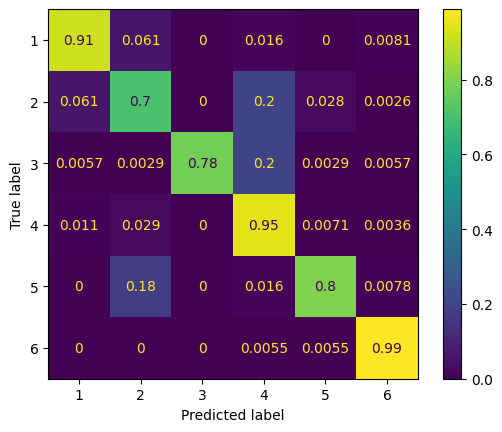

              precision    recall  f1-score   support

           1       0.89      0.91      0.90       247
           2       0.73      0.70      0.72       392
           3       1.00      0.77      0.87       353
           4       0.42      0.91      0.57       293
           5       0.95      0.77      0.85       398
           6       0.71      0.79      0.75       678
           7       0.85      0.64      0.73       792
           8       0.75      0.65      0.69       605
           9       0.93      0.99      0.96       285

    accuracy                           0.76      4043
   macro avg       0.80      0.79      0.78      4043
weighted avg       0.80      0.76      0.77      4043



In [128]:
# Predictions on test data
test_predictions = rf_model.predict(test_ds)
predicted_classes = np.argmax(test_predictions, axis=1)
true_classes = test_data[LABEL[0]].values

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes, labels=CLASSES, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot()
plt.show()

# Classification report
print(classification_report(true_classes, predicted_classes))

15
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]
3634/3634 [==============================] - 30s 8ms/step


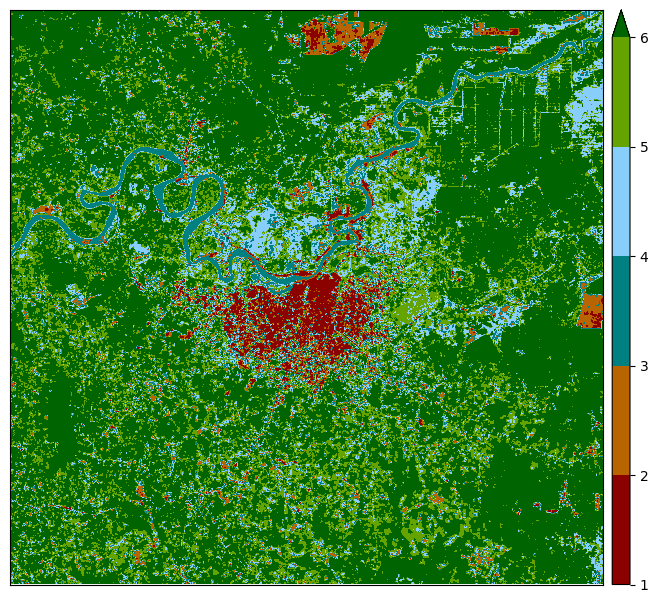

In [129]:
# Predict on image data
image_data = []

used_image_feature = [i + 1 for i in range(0, len(ALL_FEATURES)) if image.descriptions[i] in FEATURES]
print(len(ALL_FEATURES))
print(used_image_feature)
for i in used_image_feature:
    band_data = image.read(i).flatten()
    image_data.append(band_data)

# Create DataFrame for image data
image_df = pd.DataFrame(np.array(image_data).T, columns=FEATURES)

# Convert to TensorFlow dataset
image_ds = tfdf.keras.pd_dataframe_to_tf_dataset(image_df)

# Predict on image data
image_predictions = rf_model.predict(image_ds)
image_predicted_classes = np.argmax(image_predictions, axis=1)

# Reshape predictions to image dimensions
image_predicted_classes = image_predicted_classes.reshape(shape)

# Visualize the predictions
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(image_predicted_classes, cmap=cmap, norm=norm, figsize=(8, 8))
plt.show()